# Own Lesson 3 Notebook

## From Scratch Model

In [31]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image
from keras.optimizers import SGD, RMSprop, Adam
from keras.utils.np_utils import to_categorical

In [36]:
%matplotlib inline
import math, os, json, sys, re
import numpy as np
from matplotlib import pyplot as plt
import bcolz

In [4]:
path = 'dogs-cats-redux/data/sample/'
model_path = 'dogs-cats-redux/models/'
batch_size=64
os.path.exists(path)

True

In [5]:
#FILES_PATH = 'http://www.platform.ai/models/'; CLASS_FILE='imagenet_class_index.json'
#fpath = get_file(CLASS_FILE, FILES_PATH+CLASS_FILE, cache_subdir='models')
fpath = model_path + 'imagenet_class_index.json'
with open(fpath) as f: class_dict = json.load(f)
# Convert dictionary with string indexes into an array
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]
classes[:5]

[u'tench', u'goldfish', u'great_white_shark', u'tiger_shark', u'hammerhead']

In [6]:
def ConvBlock(layers, model, filters):
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

In [7]:
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

When the VGG model was trained in 2014, the creators subtracted the average of each of the three (R,G,B) channels first, so that the data for each channel had a mean of zero. Furthermore, their software that expected the channels to be in B,G,R order, whereas Python by default uses R,G,B. We need to preprocess our data to make these two changes, so that it is compatible with the VGG model:

In [8]:
# Mean of each channel as provided by VGG researchers
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))

def vgg_preprocess(x):
    x = x - vgg_mean     # subtract mean
    return x[:, ::-1]    # reverse axis bgr->rgb

In [9]:
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,224,224)))

    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation='softmax'))
    return model

In [10]:
model = VGG_16()

D:\Programs\Anaconda2\lib\site-packages\keras\keras\layers\core.py:608: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [11]:
model.load_weights(model_path + 'dogs-cats-redux-ext-epochs-weights.h5')

In [12]:
batch_size = 4

In [13]:
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, 
                batch_size=batch_size, class_mode='categorical'):
    return gen.flow_from_directory(path+dirname, target_size=(224,224), 
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

In [18]:
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        if titles is not None:
            sp.set_title(titles[i], fontsize=18)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

Found 200 images belonging to 2 classes.
Found 188 images belonging to 2 classes.


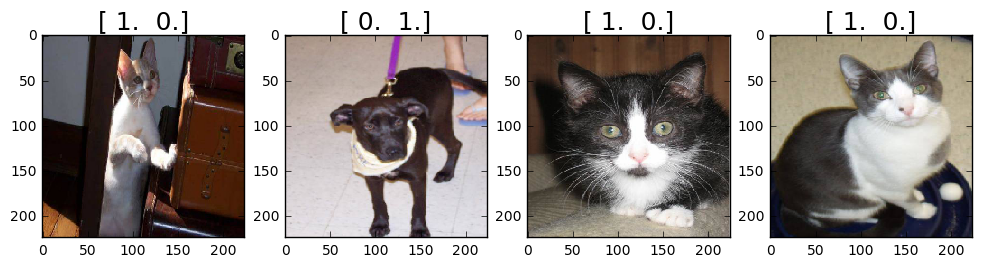

In [19]:
batches = get_batches('train', batch_size=batch_size)
val_batches = get_batches('valid', batch_size=batch_size)
imgs,labels = next(batches)

# This shows the 'ground truth'
plots(imgs, titles=labels)

## Removing dropout

Our high level approach here will be to start with our fine-tuned cats vs dogs model (with dropout), then fine-tune all the dense layers, after removing dropout from them. The steps we will take are:
- Re-create and load our modified VGG model with binary dependent (i.e. dogs v cats)
- Split the model between the convolutional (*conv*) layers and the dense layers
- Pre-calculate the output of the conv layers, so that we don't have to redundently re-calculate them on every epoch
- Create a new model with just the dense layers, and dropout p set to zero
- Train this new model using the output of the conv layers as training data.

Re-create and load our modified VGG model with binary dependent (i.e. dogs v cats)

In [22]:
model.pop()
for layer in model.layers: layer.trainable=False
model.add(Dense(2, activation='softmax'))
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
model.load_weights(model_path+'dogs-cats-redux-ext-epochs-weights.h5')

Split the model between the convolutional (conv) layers and the dense layers / pre-calculate the input to the fully connected layers - i.e. the Flatten() layer.

In [24]:
layers = model.layers

In [25]:
last_conv_idx = [index for index,layer in enumerate(layers)
                 if type(layer) is Convolution2D][-1]
last_conv_idx

30

In [26]:
layers[last_conv_idx]

In [27]:
conv_layers = layers[:last_conv_idx+1]
conv_model = Sequential(conv_layers)
# Dense layers - also known as fully connected or 'FC' layers
fc_layers = layers[last_conv_idx+1:]

In [32]:
image.ImageDataGenerator().flow_from_directory(path+'train', target_size=(224,224),
                        class_mode='categorical', shuffle=False, batch_size=batch_size)
image.ImageDataGenerator().flow_from_directory(path+'valid', target_size=(224,224),
                        class_mode='categorical', shuffle=False, batch_size=batch_size)

val_classes = val_batches.classes
trn_classes = batches.classes
val_labels = to_categorical(val_classes)
trn_labels = to_categorical(trn_classes)

Found 200 images belonging to 2 classes.
Found 188 images belonging to 2 classes.


In [34]:
val_features = conv_model.predict_generator(val_batches, val_batches.nb_sample)

In [35]:
trn_features = conv_model.predict_generator(batches, batches.nb_sample)

In [37]:
c = bcolz.carray(trn_features, rootdir=model_path + 'train_convlayer_features.bc', mode='w')
c.flush
c = bcolz.carray(val_features, rootdir=model_path + 'valid_convlayer_features.bc', mode='w')
c.flush

<function flush>

In [39]:
trn_features = bcolz.open(model_path+'train_convlayer_features.bc')[:]
val_features = bcolz.open(model_path+'valid_convlayer_features.bc')[:]
trn_features.shape

(200L, 512L, 14L, 14L)

For our new fully connected model, we'll create it using the exact same architecture as the last layers of VGG 16, so that we can conveniently copy pre-trained weights over from that model. However, we'll set the dropout layer's p values to zero, so as to effectively remove dropout.

In [40]:
# Copy the weights from the pre-trained model.
# NB: Since we're removing dropout, we want to half the weights
def proc_wgts(layer): return [o/2 for o in layer.get_weights()]

In [41]:
# Such a finely tuned model needs to be updated very slowly!
opt = RMSprop(lr=0.00001, rho=0.7)

In [42]:
def get_fc_model():
    model = Sequential([
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.),
        Dense(4096, activation='relu'),
        Dropout(0.),
        Dense(2, activation='softmax')
        ])

    for l1,l2 in zip(model.layers, fc_layers): l1.set_weights(proc_wgts(l2))

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [43]:
fc_model = get_fc_model()

In [44]:
fc_model.fit(trn_features, trn_labels, nb_epoch=8, 
             batch_size=batch_size, validation_data=(val_features, val_labels))

Train on 200 samples, validate on 188 samples
Epoch 1/1
200/200 [==============================] - 92s - loss: 1.2156 - acc: 0.5100 - val_loss: 0.9539 - val_acc: 0.5266


In [45]:
fc_model.save_weights(model_path+'no_dropout.h5')

In [ ]:
fc_model.load_weights(model_path+'no_dropout.h5')